In [1]:
from cornac.data import Reader
from cornac.datasets import movielens
from cornac.data import Dataset, FeatureModality
from cornac.eval_methods import RatioSplit, StratifiedSplit
from cornac.metrics import RMSE
from cornac.models import ItemKNN, UserKNN, NMF, BPR, MF, VAECF, NeuMF, PMF, WMF

# from MF import MF
import pandas as pd
import numpy as np
import cornac
import math

# import seaborn as sns
# import matplotlib.pyplot as plt

/Users/tahsinalamgirkheya/anaconda3/envs/re-ranking/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rating_data_pd = pd.read_csv(
    "../data/ml-1m/indexed_interactions.csv",
    sep="\t",
    header=0,
    names=["userID", "itemID", "Rating", "Timestamp"],
)
rating_data = rating_data_pd.to_numpy()
rating_data.__len__()
rating_data_pd

,userID,itemID,Rating,Timestamp
0,0,0,5,978300760
1,0,1,3,978302109
2,0,2,3,978301968
3,0,3,4,978300275
4,0,4,5,978824291
...,...,...,...,...
999606,6039,772,1,956716541
999607,6039,1106,5,956704887
999608,6039,365,5,956704746
999609,6039,152,4,956715648


In [3]:
movie = "../data/ml-1m/i_id_mapping_genre.csv"

df_movie = pd.read_csv(movie, sep="\t")
print(f"shape: {df_movie.shape}")


df_movie.columns = ["item_id", "Name", "genres", "itemID"]
df_movie[:4]
movies = df_movie.sort_values(by="itemID")
unique_genres = [
    "Action",
    "Thriller",
    "Romance",
    "Western",
    "Children's",
    "Mystery",
    "Fantasy",
    "Film-Noir",
    "Documentary",
    "Comedy",
    "Adventure",
    "Sci-Fi",
    "Horror",
    "Crime",
    "Musical",
    "War",
    "Animation",
    "Drama",
]
for genre in unique_genres:
    movies[genre] = 0

for index, row in movies.iterrows():
    genres = row["genres"].split("|")
    for genre in genres:
        movies.at[index, genre] = 1
movies


movies

shape: (3416, 4)


,item_id,Name,genres,itemID,Action,Thriller,Romance,Western,Children's,Mystery,...,Documentary,Comedy,Adventure,Sci-Fi,Horror,Crime,Musical,War,Animation,Drama
0,1193,One Flew Over the Cuckoo's Nest (1975),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,661,James and the Giant Peach (1996),Animation|Children's|Musical,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
2,914,My Fair Lady (1964),Musical|Romance,2,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,3408,Erin Brockovich (2000),Drama,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,4,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,2833,Lucie Aubrac (1997),Romance|War,3411,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3412,3207,"Snows of Kilimanjaro, The (1952)",Adventure,3412,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3413,3533,"Actor's Revenge, An (Yukinojo Henge) (1963)",Drama,3413,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3414,2777,Cobra (1925),Drama,3414,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
movies = movies.drop(columns=["item_id"])
movies = movies.sort_values(by="itemID")
movies

,Name,genres,itemID,Action,Thriller,Romance,Western,Children's,Mystery,Fantasy,...,Documentary,Comedy,Adventure,Sci-Fi,Horror,Crime,Musical,War,Animation,Drama
0,One Flew Over the Cuckoo's Nest (1975),Drama,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,James and the Giant Peach (1996),Animation|Children's|Musical,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,My Fair Lady (1964),Musical|Romance,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,Erin Brockovich (2000),Drama,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,"Bug's Life, A (1998)",Animation|Children's|Comedy,4,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,Lucie Aubrac (1997),Romance|War,3411,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3412,"Snows of Kilimanjaro, The (1952)",Adventure,3412,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3413,"Actor's Revenge, An (Yukinojo Henge) (1963)",Drama,3413,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3414,Cobra (1925),Drama,3414,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
users = pd.read_csv("../data/ml-1m/u_id_mapping_demographic.csv", sep="\t")
# users


users = users.sort_values(by="userID")

users = users.drop(columns=users.columns[0])
gender_map = {"M": 0, "F": 1}
users["Gender"] = users["Gender"].map(gender_map)
# user_features_numpy = users.to_numpy()
users

,Gender,Age,Occupation,ZipCode,userID
0,1,1,10,48067,0
1,0,56,16,70072,1
2,0,25,15,55117,2
3,0,45,7,02460,3
4,0,25,20,55455,4
...,...,...,...,...,...
6035,1,25,15,32603,6035
6036,1,45,1,76006,6036
6037,1,56,1,14706,6037
6038,1,45,0,01060,6038


In [6]:
dataset = rating_data
dataset

array([[        0,         0,         5, 978300760],
       [        0,         1,         3, 978302109],
       [        0,         2,         3, 978301968],
       ...,
       [     6039,       365,         5, 956704746],
       [     6039,       152,         4, 956715648],
       [     6039,        26,         4, 956715569]])

In [7]:
rating_data_pd[rating_data_pd["itemID"] == 3414]

,userID,itemID,Rating,Timestamp
472590,2906,3414,4,972180772
553042,3404,3414,1,974166554
615444,3726,3414,1,966221386
739661,4421,3414,3,965155047
966980,5830,3414,1,1024075428


In [8]:
ratio_split = StratifiedSplit(
    data=dataset,
    test_size=0.2,
    rating_threshold=0.0,
    seed=123,
    verbose=True,
    chrono=True,
    exclude_unknowns=False,
)

hr_10 = cornac.metrics.HitRatio(k=20)
ndcg_10 = cornac.metrics.NDCG(k=20)
recall_10 = cornac.metrics.Recall(k=20)
prec_10 = cornac.metrics.Precision(k=20)
auc = cornac.metrics.AUC()
map = cornac.metrics.MAP()

epochs = [40, 60, 80, 100, 120, 140, 160, 180, 200]
epochs = [200]
models = []
# WMF(name=f'WMF{epochs[i]}', k=200, lambda_u=0.01, lambda_v=0.01, a=1, b=0.01, learning_rate=0.001, batch_size=128, max_iter=80,
# trainable=True, verbose=True, init_params=None, seed=123)
   
# class cornac.models.vaecf.recom_vaecf.
# VAECF(name='VAECF', k=10, autoencoder_structure=[20], act_fn='tanh',
# likelihood='mult', n_epochs=100, batch_size=100, learning_rate=0.001, beta=1.0, trainable=True, verbose=False, seed=None, use_gpu=False)[source]
for i in range(len(epochs)):
    models.append(
      MF(
            name=f"MF{epochs[i]}",
            k=40,
            backend="cpu",
            optimizer="adam",
            max_iter=epochs[i],
            learning_rate=0.001,
            batch_size=1024,
            # lambda_reg=0.02,
            dropout=0.0,
            use_bias=True,
            early_stop=False,
            num_threads=0,
            trainable=True,
            verbose=True,
            init_params=None,
            seed=123,
        )
    )
    
    
    # VAECF(
    #         k=50,
    #         autoencoder_structure=[ 128, 64],
    #         act_fn="relu",
    #         likelihood="bern",
    #         n_epochs=40,
    #         batch_size=512,
    #         learning_rate=0.0005, 
    #         alpha=alpha_values[i],
    #         top_k=50,
    #         beta=1,
    #         name=f"a={alpha_values[i]} vae",
    #         seed=123,
    #         verbose=True,save_dir="./model_saved/"
    #         # early_stopping=True
        
    # ))

# model = MF(
#             name=f"MF{40}",
#             k=10,
#             backend="cpu",
#             optimizer="adam",
#             max_iter=40,
#             learning_rate=0.01,
#             batch_size=256,
#             lambda_reg=0.02,
#             dropout=0.0,
#             use_bias=True,
#             early_stop=False,
#             num_threads=0,
#             trainable=True,
#             verbose=False,
#             init_params=None,
#             seed=123,
#         )
#  NeuMF(
#             name=f"NeuMFe={epochs[i]}",
#             num_factors=16,
#             layers=(64, 32,16),
#             act_fn="sigmoid",
#             reg=0.0,
#             num_epochs=40,
#             batch_size=1024,
#             num_neg=3,
#             lr=0.001,
#             learner="adam",
#             backend="tensorflow",
#             early_stopping=None,
#             trainable=True,
#             verbose=True,
#             seed=123,
#         )
# # model=VAECF(k=10, autoencoder_structure=[20], name="vae100",act_fn="tanh", likelihood="mult", n_epochs=100, batch_size=100, learning_rate=0.001, beta=1.0, seed=123, verbose=True)

# models = [model]
cornac.Experiment(
    ratio_split, models=models, metrics=[hr_10, ndcg_10, recall_10, auc, prec_10, map]
).run()

rating_threshold = 0.0
exclude_unknowns = False
---
Training data:
Number of users = 6040
Number of items = 3415
Number of ratings = 797275
Max rating = 5.0
Min rating = 1.0
Global mean = 3.6
---
Test data:
Number of users = 6040
Number of items = 3416
Number of ratings = 202336
Number of unknown users = 0
Number of unknown items = 1
---
Total users = 6040
Total items = 3416

[MF200] Training started!


100%|██████████| 200/200 [00:04<00:00, 43.31it/s, loss=201680.23]


Optimization finished!

[MF200] Evaluation started!


Ranking: 100%|██████████| 6040/6040 [00:06<00:00, 998.25it/s] 


TEST:
...
      |    AUC | HitRatio@20 |    MAP | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
----- + ------ + ----------- + ------ + ------- + ------------ + --------- + --------- + --------
MF200 | 0.6479 |      0.4222 | 0.0356 |  0.0625 |       0.0519 |    0.0358 |    4.6458 |   6.0984



In [ ]:
           |    AUC | HitRatio@20 |    MAP | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
---------- + ------ + ----------- + ------ + ------- + ------------ + --------- + --------- + --------
NeuMFe=40  | 0.8690 |      0.7498 | 0.0832 |  0.1222 |       0.0953 |    0.0991 |  608.5366 |  11.7413
NeuMFe=60  | 0.8659 |      0.7348 | 0.0795 |  0.1153 |       0.0900 |    0.0933 |  930.3179 |  10.7331
NeuMFe=80  | 0.8650 |      0.7381 | 0.0781 |  0.1138 |       0.0894 |    0.0920 | 1261.2915 |  10.8076
NeuMFe=100 | 0.8648 |      0.7467 | 0.0779 |  0.1137 |       0.0904 |    0.0916 | 1702.1451 |   9.9542
NeuMFe=120 | 0.8633 |      0.7389 | 0.0757 |  0.1102 |       0.0883 |    0.0892 | 1742.6324 |  10.9617
NeuMFe=140 | 0.8628 |      0.7343 | 0.0758 |  0.1105 |       0.0882 |    0.0889 | 2044.2912 |  10.8152
NeuMFe=160 | 0.8632 |      0.7349 | 0.0759 |  0.1108 |       0.0884 |    0.0887 | 2418.4246 |  11.4533
NeuMFe=180 | 0.8626 |      0.7414 | 0.0751 |  0.1095 |       0.0876 |    0.0876 | 2700.3938 |  10.8927
NeuMFe=200 | 0.8626 |      0.7392 | 0.0752 |  0.1097 |       0.0878 |    0.0873 | 3088.6612 |  10.9185
NeuMF(
            name=f"NeuMFe={epochs[i]}",
            num_factors=64,
            layers=(128,64),
            act_fn="relu",
            reg=0.0,
            num_epochs=epochs[i],
            batch_size=1024,
            num_neg=3,
            lr=0.001,
            learner="adam",
            backend="tensorflow",
            early_stopping=None,
            trainable=True,
            verbose=True,
            seed=123,
        )

           |    AUC | HitRatio@20 |    MAP | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
---------- + ------ + ----------- + ------ + ------- + ------------ + --------- + --------- + --------
NeuMFe=40  | 0.8872 |      0.7528 | 0.0978 |  0.1406 |       0.1103 |    0.1069 |  537.1554 |   8.6218
NeuMFe=60  | 0.8835 |      0.7502 | 0.0946 |  0.1372 |       0.1082 |    0.1045 |  798.6666 |   9.0573
NeuMFe=80  | 0.8803 |      0.7430 | 0.0919 |  0.1342 |       0.1056 |    0.1026 | 1065.1405 |   8.8466
NeuMFe=100 | 0.8767 |      0.7460 | 0.0887 |  0.1294 |       0.1024 |    0.0994 | 1324.6613 |   8.9825
NeuMFe=120 | 0.8746 |      0.7447 | 0.0867 |  0.1265 |       0.1010 |    0.0974 | 1579.9904 |   8.9423
NeuMFe=140 | 0.8715 |      0.7369 | 0.0844 |  0.1236 |       0.0992 |    0.0953 | 1874.8860 |   8.5331
NeuMFe=160 | 0.8691 |      0.7290 | 0.0822 |  0.1192 |       0.0966 |    0.0922 | 2145.6737 |   9.0116
NeuMFe=180 | 0.8671 |      0.7205 | 0.0804 |  0.1168 |       0.0954 |    0.0905 | 2438.3545 |   9.3830
NeuMFe=200 | 0.8654 |      0.7235 | 0.0799 |  0.1163 |       0.0947 |    0.0894 | 2665.9253 |   9.2421
 NeuMF(
            name=f"NeuMFe={epochs[i]}",
            num_factors=16,
            layers=(64, 32,16),
            act_fn="sigmoid",
            reg=0.0,
            num_epochs=epochs[i],
            batch_size=1024,
            num_neg=3,
            lr=0.001,
            learner="adam",
            backend="tensorflow",
            early_stopping=None,
            trainable=True,
            verbose=True,
            seed=123,
        )
 
           |    AUC | HitRatio@20 |    MAP | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
--------- + ------ + ----------- + ------ + ------- + ------------ + --------- + --------- + --------
NeuMFe=40 | 0.8805 |      0.7584 | 0.0933 |  0.1365 |       0.1068 |    0.1085 |  751.6690 |  10.3999

 models.append(
        NeuMF(
            name=f"NeuMFe={epochs[i]}",
            num_factors=32,
            layers=( 128,64,32),
            act_fn="sigmoid",
            reg=0.0,
            num_epochs=epochs[i],
            batch_size=1024,
            num_neg=4,
            lr=0.001,
            learner="adam",
            backend="tensorflow",
            early_stopping=None,
            trainable=True,
            verbose=True,
            seed=123,
        )
    )

In [ ]:
0.46158940397350995
      VAECF(k=50, autoencoder_structure=[128, 64], name=f"vae{epochs[i]}",act_fn="relu", likelihood="bern", n_epochs=epochs[i], batch_size=512, learning_rate=0.001, beta=1.0, seed=123, verbose=True)


In [9]:
models 

In [10]:
user_ids = users["userID"].to_numpy()
item_ids = movies["itemID"].to_numpy()
user_ids.__len__()

6040

In [181]:
models=[models]

In [11]:
# get the top_k ratings for all users:
top_k = 1000
reco_matrix = np.zeros((len(models), len(user_ids), top_k), dtype=int)
reco_matrix_mapped_items = np.zeros(
    (len(models), len(user_ids), len(item_ids)), dtype=int
)
reco_matrix_mapped_scores = np.zeros(
    (len(models), len(user_ids), len(item_ids)), dtype=float
)
reco_matrix_all = np.zeros((len(models), len(user_ids), len(item_ids)), dtype=int)


for u in user_ids:
    for i in range(len(models)):
        reco_items = models[i].recommend(u)
        # print(reco_items.__len__())
        items_mapped, mapped_scores = models[i].rank(
            user_idx=u, item_indices=list(item_ids)
        )
        reco_matrix_mapped_items[i][u] = items_mapped
        reco_matrix_mapped_scores[i][u] = mapped_scores
        reco_matrix_all[i][u] = reco_items
        reco_matrix[i][u] = reco_items[:top_k]

        # print(reco_matrix[0][3])

In [12]:
reco_matrix.shape

(1, 6040, 1000)

In [124]:
test_set_data = pd.DataFrame(ratio_split.test_set.uir_tuple).transpose()
test_set_data.columns = ["uid", "iid", "rating"]
test_set_data = test_set_data.astype({"uid": "int", "iid": "int", "rating": "int"})
r_global_uid_map = {v: k for k, v in ratio_split.global_uid_map.items()}
r_global_iid_map = {v: k for k, v in ratio_split.global_iid_map.items()}

test_set_data["uid"] = test_set_data["uid"].map(r_global_uid_map)
test_set_data["iid"] = test_set_data["iid"].map(r_global_iid_map)
test_set_data

,uid,iid,rating
0,6039,373,4
1,6039,221,3
2,6039,2602,4
3,6039,132,4
4,6039,350,4
...,...,...,...
202331,2946,885,3
202332,2946,343,3
202333,2946,151,4
202334,2946,1792,4


In [125]:
all_users_tp = test_set_data.groupby('uid')['iid'].apply(list).tolist()
all_users_tp.__len__()


6040

In [153]:

from cornac.metrics import RMSE, AUC, NDCG, Precision, Recall,HitRatio

hr=HitRatio(20)
alist=[]
o=0

sum_hr=0
for u in range(reco_matrix[o].shape[0]):
    x=hr.compute(all_users_tp[u],reco_matrix[o][u][:20])
    sum_hr=sum_hr+x
plain_hr=sum_hr/reco_matrix[o].shape[0]

plain_hr


0.46158940397350995

In [48]:
rating_data_pd[rating_data_pd["userID"] == 3].sort_values(by="itemID")

,userID,itemID,Rating,Timestamp
244,3,26,4,978293964
251,3,43,5,978294230
238,3,44,5,978294199
239,3,48,5,978294230
233,3,63,5,978294008
234,3,64,3,978293924
240,3,113,4,978294008
241,3,124,2,978294199
242,3,127,5,978294199
243,3,139,5,978294282


In [43]:
train_set_data = pd.DataFrame(ratio_split.train_set.uir_tuple).transpose()
train_set_data.columns = ["uid", "iid", "rating"]
train_set_data = train_set_data.astype({"uid": "int", "iid": "int", "rating": "int"})
r_global_uid_map = {v: k for k, v in ratio_split.global_uid_map.items()}
r_global_iid_map = {v: k for k, v in ratio_split.global_iid_map.items()}

train_set_data["uid"] = train_set_data["uid"].map(r_global_uid_map)
train_set_data["iid"] = train_set_data["iid"].map(r_global_iid_map)

In [51]:
train_set_data[train_set_data["uid"] == 3].sort_values(by="iid").__len__()

16

In [52]:
test_set_data.to_csv("testing_set_seed123_ml1m.csv", index=False, header=False)

In [53]:
train_set_data.to_csv("training_set_seed123_ml1m.csv", index=False, header=False)

In [56]:
reco_matrix[0]

array([[   0,   45,   14, ..., 2107, 3258, 2581],
       [ 128,   23,  546, ..., 2302, 2262, 2917],
       [ 196,  206,    5, ..., 1140, 2868,  508],
       ...,
       [ 535, 1509,  539, ..., 2953, 2008, 2932],
       [ 617,  726,   44, ..., 3300,  407,  324],
       [ 611, 1584,  420, ...,  649, 1016,  831]])

In [13]:
np.save("reco_matrix_mf_1m_1000", reco_matrix)

In [15]:
from collections import OrderedDict

# uid_map (OrderDict, required) – The dictionary containing mapping from user original ids to mapped integer indices.

# iid_map (OrderDict, required) – The dictionary containing mapping from item original ids to mapped integer indices.
sorted_by_values = OrderedDict(
    sorted(models[0].iid_map.items(), key=lambda item: item[1])
)
keys_sorted_by_values = list(sorted_by_values.keys())

reco_items_scores_all = [OrderedDict() for _ in range(len(user_ids))]

for u in user_ids:
    actual_index_u = u
    mapped_index_u = models[0].uid_map[actual_index_u]
    # print(f"u {u} mapped u {mapped_index_u}")

    # for i in item_ids:
    mapped_scores = reco_matrix_mapped_scores[0][mapped_index_u]
    ordered_dict = OrderedDict(zip(keys_sorted_by_values, mapped_scores))
    reco_items_scores_all[actual_index_u] = ordered_dict

In [186]:
reco_items_scores_all[0]

OrderedDict([(669, 4.637978553771973),
             (128, 4.6290178298950195),
             (323, 3.4720869064331055),
             (41, 4.364929676055908),
             (1092, 4.5291619300842285),
             (2739, 3.9409706592559814),
             (1615, 4.150184154510498),
             (2509, 4.3217291831970215),
             (1551, 3.984316825866699),
             (1234, 4.203221797943115),
             (346, 3.6496756076812744),
             (420, 4.478252410888672),
             (9, 4.575643539428711),
             (3344, 4.710315227508545),
             (23, 4.712100028991699),
             (2463, 4.513803958892822),
             (167, 4.700977802276611),
             (559, 4.2415947914123535),
             (3018, 4.054640293121338),
             (2576, 4.276618003845215),
             (104, 4.093681812286377),
             (51, 4.207080841064453),
             (134, 4.0699591636657715),
             (1948, 4.285622596740723),
             (309, 3.9957618713378906),
          

In [60]:
models[0].uid_map.items()

odict_items([(6039, 0), (6038, 1), (6037, 2), (6036, 3), (6035, 4), (6034, 5), (6033, 6), (6032, 7), (6031, 8), (6030, 9), (6029, 10), (6028, 11), (6027, 12), (6026, 13), (6025, 14), (6024, 15), (6023, 16), (6022, 17), (6021, 18), (6020, 19), (6019, 20), (6018, 21), (6017, 22), (6016, 23), (6015, 24), (6014, 25), (6013, 26), (6012, 27), (6011, 28), (6010, 29), (6009, 30), (6008, 31), (6006, 32), (6007, 33), (6005, 34), (6004, 35), (6003, 36), (6002, 37), (6001, 38), (6000, 39), (5999, 40), (5998, 41), (5997, 42), (5996, 43), (5995, 44), (5994, 45), (5993, 46), (5992, 47), (5991, 48), (5990, 49), (5989, 50), (5988, 51), (5987, 52), (5986, 53), (5985, 54), (5983, 55), (5982, 56), (5981, 57), (5980, 58), (5978, 59), (5979, 60), (5977, 61), (5976, 62), (5975, 63), (5974, 64), (5973, 65), (5972, 66), (5971, 67), (5970, 68), (5969, 69), (5968, 70), (5967, 71), (5966, 72), (5965, 73), (5964, 74), (5963, 75), (5962, 76), (5961, 77), (5960, 78), (5959, 79), (5958, 80), (5957, 81), (5956, 82), (

In [61]:
models[0].iid_map.items()

odict_items([(669, 0), (128, 1), (323, 2), (41, 3), (1092, 4), (2739, 5), (1615, 6), (2509, 7), (1551, 8), (1234, 9), (346, 10), (420, 11), (9, 12), (3344, 13), (23, 14), (2463, 15), (167, 16), (559, 17), (3018, 18), (2576, 19), (104, 20), (51, 21), (134, 22), (1948, 23), (309, 24), (48, 25), (417, 26), (381, 27), (38, 28), (795, 29), (43, 30), (246, 31), (2504, 32), (520, 33), (225, 34), (39, 35), (2506, 36), (365, 37), (109, 38), (55, 39), (271, 40), (1976, 41), (229, 42), (529, 43), (505, 44), (141, 45), (958, 46), (986, 47), (280, 48), (1106, 49), (259, 50), (1276, 51), (276, 52), (361, 53), (439, 54), (97, 55), (336, 56), (453, 57), (291, 58), (1163, 59), (95, 60), (922, 61), (1970, 62), (382, 63), (176, 64), (1235, 65), (105, 66), (1545, 67), (743, 68), (1098, 69), (1911, 70), (2498, 71), (2568, 72), (2698, 73), (1348, 74), (71, 75), (87, 76), (411, 77), (1297, 78), (1586, 79), (217, 80), (84, 81), (1584, 82), (124, 83), (127, 84), (1241, 85), (1915, 86), (1298, 87), (210, 88), (

In [62]:
models[0].rank(1)

(array([284, 256, 194, ..., 446, 535, 509]),
 array([3.672328  , 3.10983706, 2.02027988, ..., 0.05084449, 0.28072688,
        0.27956942]))

In [66]:
reco_items_scores_all[6038][669]

3.672327995300293

In [19]:
i, s = models[0].rank(98, item_ids)
print(s.__len__())
np.argsort(s)[-10:][::-1]

1348


array([303,  17,  25, 193, 136,   9, 466, 380, 147, 421])

In [ ]:
matching_keys = [key for key, value in models[0].iid_map.items() if value == 35]
matching_keys

In [18]:
reco_matrix.shape

(1, 6040, 1000)

In [16]:
import pickle

with open("score_dicts_mf1m.pkl", "wb") as file:
    pickle.dump(reco_items_scores_all, file)

print("List of OrderedDicts saved to 'score_dicts.pkl'.")

List of OrderedDicts saved to 'score_dicts.pkl'.


In [ ]:
reco_matrix[0][0]

In [ ]:
reco_items_scores_all[98]

In [ ]:
x = OrderedDict(
    sorted(reco_items_scores_all[772].items(), key=lambda item: item[1], reverse=True)
)
x

In [19]:
rating_data_pd

,userID,itemID,Rating,Timestamp
0,0,0,5,978300760
1,0,1,3,978302109
2,0,2,3,978301968
3,0,3,4,978300275
4,0,4,5,978824291
...,...,...,...,...
999606,6039,772,1,956716541
999607,6039,1106,5,956704887
999608,6039,365,5,956704746
999609,6039,152,4,956715648


In [20]:
users

,Gender,Age,Occupation,ZipCode,userID
0,1,1,10,48067,0
1,0,56,16,70072,1
2,0,25,15,55117,2
3,0,45,7,02460,3
4,0,25,20,55455,4
...,...,...,...,...,...
6035,1,25,15,32603,6035
6036,1,45,1,76006,6036
6037,1,56,1,14706,6037
6038,1,45,0,01060,6038


In [30]:
merged_pd = pd.merge(rating_data_pd, users, on = "userID")

merged_pd["Age_Code"] = merged_pd["Age"].apply(map_age)

merged_pd

,userID,itemID,Rating,Timestamp,Gender,Age,Occupation,ZipCode,Age_Code
0,0,0,5,978300760,1,1,10,48067,0
1,0,1,3,978302109,1,1,10,48067,0
2,0,2,3,978301968,1,1,10,48067,0
3,0,3,4,978300275,1,1,10,48067,0
4,0,4,5,978824291,1,1,10,48067,0
...,...,...,...,...,...,...,...,...,...
999606,6039,772,1,956716541,0,25,6,11106,2
999607,6039,1106,5,956704887,0,25,6,11106,2
999608,6039,365,5,956704746,0,25,6,11106,2
999609,6039,152,4,956715648,0,25,6,11106,2


In [29]:
def map_age(age):
    if age < 18:
        return 0
    elif 18 <= age <= 24:
        return 1
    elif 25 <= age <= 34:
        return 2
    elif 35 <= age <= 44:
        return 3
    elif 45 <= age <= 49:
        return 4
    elif 50 <= age <= 55:
        return 5
    else:
        return 6


In [ ]:
merged_pd = pd.merge( merged_pd, movies[["itemID", "genres"]], on = "itemID")


,userID,itemID,Rating,Timestamp,Gender,Age,Occupation,ZipCode,Age_Code,genres
0,0,0,5,978300760,1,1,10,48067,0,Drama
1,0,1,3,978302109,1,1,10,48067,0,Animation|Children's|Musical
2,0,2,3,978301968,1,1,10,48067,0,Musical|Romance
3,0,3,4,978300275,1,1,10,48067,0,Drama
4,0,4,5,978824291,1,1,10,48067,0,Animation|Children's|Comedy
...,...,...,...,...,...,...,...,...,...,...
999606,6039,772,1,956716541,0,25,6,11106,2,Comedy
999607,6039,1106,5,956704887,0,25,6,11106,2,Drama|Romance|War
999608,6039,365,5,956704746,0,25,6,11106,2,Comedy|Drama
999609,6039,152,4,956715648,0,25,6,11106,2,Drama


In [38]:
df = merged_pd

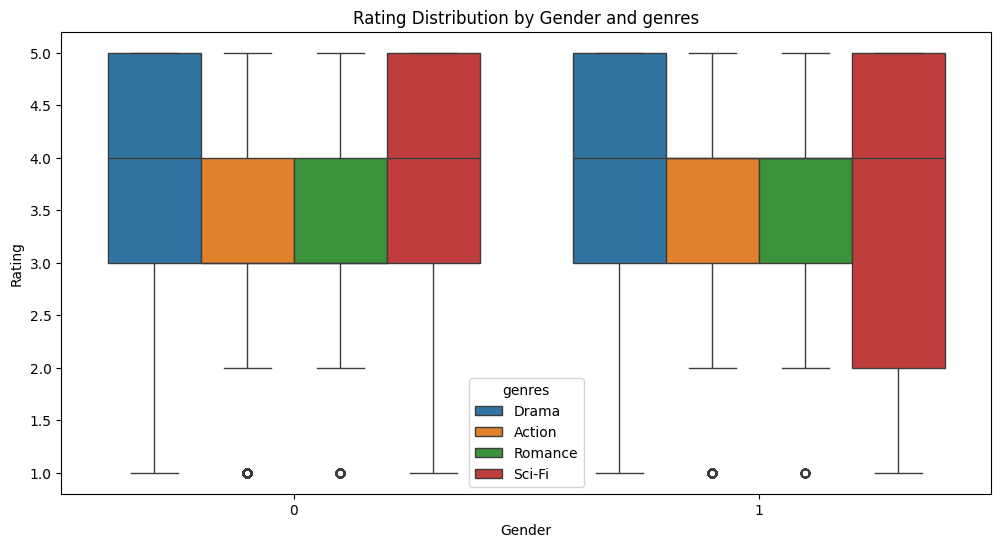

ValueError: Bin labels must be one fewer than the number of bin edges

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and the genre column is called 'Genre'

# Step 1: Split the Genre column and "explode" it
df['Genre'] = df['genres'].str.split('|')  # Split the genres by the pipe '|'
df_exploded = df.explode('genres')  # Create a row for each genre

# Step 2: Filter for the genres of interest (Action, Romance, Sci-Fi, Drama)
genres_of_interest = ['Action', 'Romance', 'Sci-Fi', 'Drama']
df_genres = df_exploded[df_exploded['genres'].isin(genres_of_interest)]

# Step 3: Boxplot for Gender vs Genre ratings
plt.figure(figsize=(12, 6))
sns.boxplot(x='Gender', y='Rating', hue='genres', data=df_genres)
plt.title('Rating Distribution by Gender and genres')
plt.xlabel('Gender')
plt.ylabel('Rating')
plt.show()

# Step 4: Boxplot for Age Group vs Genre ratings
age_bins = [0, 18, 24, 34, 44, 54, 64, 100]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df_genres['AgeGroup'] = pd.cut(df_genres['Age'], bins=age_bins, labels=age_labels)

plt.figure(figsize=(12, 6))
sns.boxplot(x='AgeGroup', y='Rating', hue='genres', data=df_genres)
plt.title('Rating Distribution by Age Group and Genre')
plt.xlabel('Age Group')
plt.ylabel('Rating')
plt.show()

# Step 5: Boxplot for Occupation vs Genre ratings
plt.figure(figsize=(14, 6))  # Adjust width for better readability
sns.boxplot(x='Occupation', y='Rating', hue='genres', data=df_genres)
plt.title('Rating Distribution by Occupation and genres')
plt.xlabel('Occupation')
plt.ylabel('Rating')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.show()


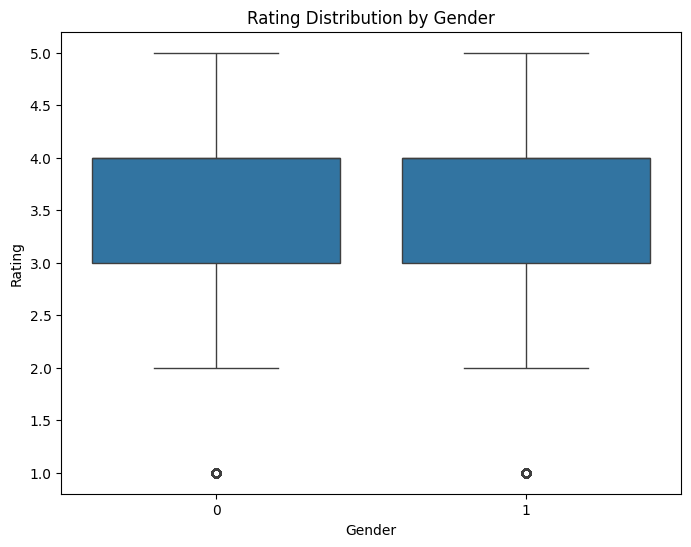

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
plt.figure(figsize=(8, 6))

# Create a boxplot of ratings by gender
sns.boxplot(x='Gender', y='Rating', data=merged_pd)

# Add title and labels
plt.title('Rating Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Rating')

# Show the plot
plt.show()


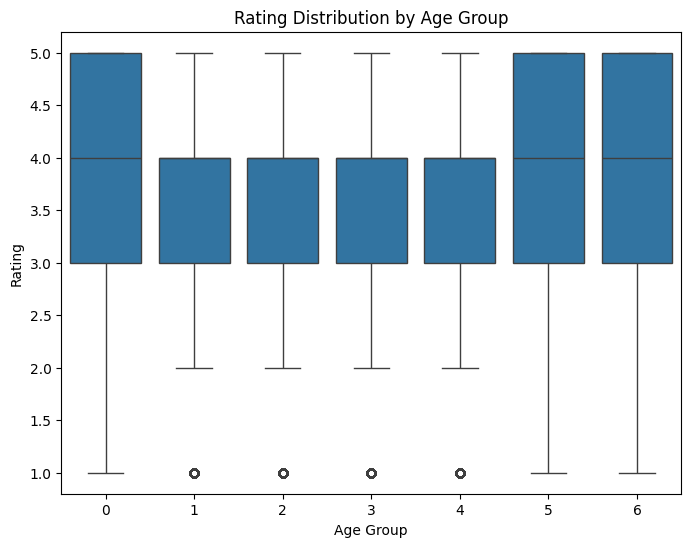

In [33]:
# Create age bins and labels
age_bins = [0, 18, 24, 34, 44, 54, 64, 100]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Create a new column 'AgeGroup' with the categorized age data

# Create the boxplot for AgeGroup vs Ratings
plt.figure(figsize=(8, 6))
sns.boxplot(x='Age_Code', y='Rating', data=merged_pd)

# Add title and labels
plt.title('Rating Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Rating')

# Show the plot
plt.show()


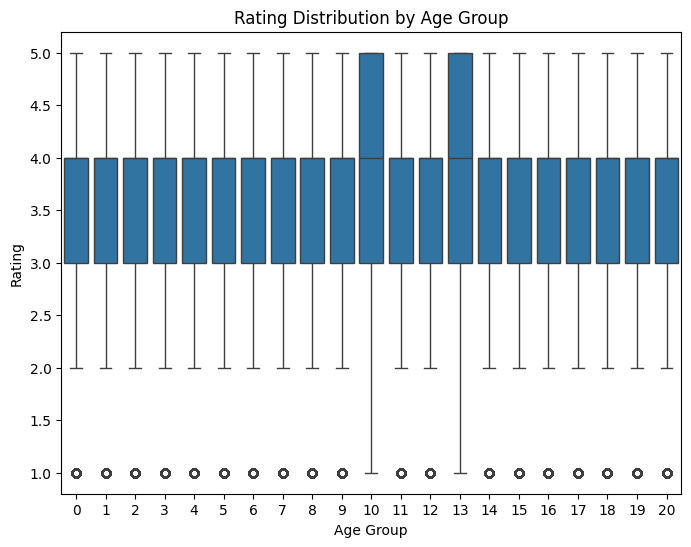

In [34]:
# Create age bins and labels


# Create a new column 'AgeGroup' with the categorized age data

# Create the boxplot for AgeGroup vs Ratings
plt.figure(figsize=(8, 6))
sns.boxplot(x='Occupation', y='Rating', data=merged_pd)

# Add title and labels
plt.title('Rating Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Rating')

# Show the plot
plt.show()


In [42]:
(0.1254-0.0297)/0.1254

0.7631578947368421